In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
#tf.get_logger().setLevel('ERROR') # turn off tf warnings 
import tensorflow as tf
import glob
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# prepare numerical data

In [3]:
train = pd.read_csv('/content/drive/MyDrive/MSCA/msca31009/train.csv')

In [4]:
train.head()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,margin10,margin11,margin12,margin13,margin14,margin15,margin16,margin17,margin18,margin19,margin20,margin21,margin22,margin23,margin24,margin25,margin26,margin27,margin28,margin29,margin30,margin31,margin32,margin33,margin34,margin35,margin36,margin37,margin38,...,texture25,texture26,texture27,texture28,texture29,texture30,texture31,texture32,texture33,texture34,texture35,texture36,texture37,texture38,texture39,texture40,texture41,texture42,texture43,texture44,texture45,texture46,texture47,texture48,texture49,texture50,texture51,texture52,texture53,texture54,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,0.001953,0.033203,0.013672,0.019531,0.066406,0.000000,0.029297,0.0,0.031250,0.011719,0.000000,0.025391,0.023438,0.001953,0.0,0.015625,0.000000,0.031250,0.000000,0.013672,0.029297,0.015625,0.011719,0.003906,0.025391,0.000000,0.001953,0.011719,0.009766,0.041016,...,0.008789,0.015625,0.044922,0.000000,0.037109,0.012695,0.028320,0.000000,0.019531,0.026367,0.005859,0.0,0.004883,0.016602,0.034180,0.056641,0.006836,0.000977,0.022461,0.037109,0.004883,0.021484,0.035156,0.000977,0.004883,0.015625,0.000000,0.0,0.006836,0.037109,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,0.000000,0.007812,0.003906,0.027344,0.023438,0.000000,0.033203,0.0,0.009766,0.009766,0.007812,0.007812,0.019531,0.007812,0.0,0.000000,0.007812,0.027344,0.003906,0.037109,0.007812,0.048828,0.054688,0.027344,0.003906,0.000000,0.000000,0.003906,0.013672,0.033203,...,0.050781,0.001953,0.021484,0.003906,0.027344,0.023438,0.062500,0.000000,0.038086,0.000000,0.019531,0.0,0.001953,0.003906,0.015625,0.004883,0.104490,0.000000,0.061523,0.007812,0.008789,0.013672,0.011719,0.001953,0.035156,0.007812,0.000000,0.0,0.053711,0.036133,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,0.000000,0.044922,0.007812,0.011719,0.021484,0.001953,0.025391,0.0,0.009766,0.011719,0.007812,0.005859,0.041016,0.001953,0.0,0.015625,0.000000,0.009766,0.001953,0.009766,0.009766,0.015625,0.005859,0.000000,0.017578,0.007812,0.005859,0.009766,0.019531,0.042969,...,0.000977,0.000000,0.000977,0.003906,0.035156,0.015625,0.027344,0.000000,0.000000,0.008789,0.015625,0.0,0.000000,0.011719,0.000977,0.000977,0.000000,0.000000,0.000000,0.005859,0.022461,0.020508,0.021484,0.056641,0.010742,0.008789,0.000000,0.0,0.000977,0.000000,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,0.013672,0.017578,0.001953,0.019531,0.001953,0.003906,0.035156,0.0,0.005859,0.000000,0.001953,0.003906,0.039062,0.009766,0.0,0.009766,0.005859,0.027344,0.001953,0.017578,0.003906,0.021484,0.027344,0.027344,0.000000,0.003906,0.011719,0.003906,0.005859,0.044922,...,0.005859,0.019531,0.124020,0.000000,0.017578,0.000977,0.016602,0.009766,0.006836,0.000977,0.005859,0.0,0.000977,0.001953,0.096680,0.016602,0.126950,0.000000,0.036133,0.055664,0.000000,0.001953,0.027344,0.000000,0.006836,0.017578,0.004883,0.0,0.006836,0.022461,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,0.000000,0.005859,0.001953,0.044922,0.041016,0.011719,0.041016,0.0,0.009766,0.015625,0.011719,0.007812,0.021484,0.000000,0.0,0.000000,0.015625,0.009766,0.001953,0.017578,0.041016,0.005859,0.021484,0.013672,0.017578,0.000000,0.005859,0.009766,0.027344,0.083984,...,0.000000,0.000000,0.040039,0.005859,0.005859,0.000000,0.003906,0.000000,0.000000,0.110350,0.000000,0.0,0.000000,0.087891,0.023

balanced class

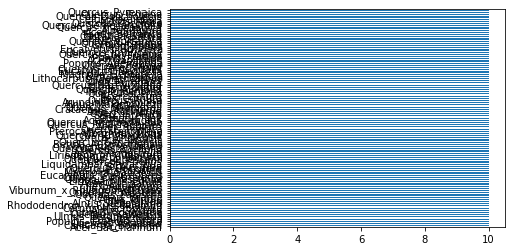

In [5]:
train['species'].value_counts().plot(kind = 'barh')
plt.show()

In [6]:
test = pd.read_csv('/content/drive/MyDrive/MSCA/msca31009/test.csv')

In [7]:
test.head()

,id,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,margin10,margin11,margin12,margin13,margin14,margin15,margin16,margin17,margin18,margin19,margin20,margin21,margin22,margin23,margin24,margin25,margin26,margin27,margin28,margin29,margin30,margin31,margin32,margin33,margin34,margin35,margin36,margin37,margin38,margin39,...,texture25,texture26,texture27,texture28,texture29,texture30,texture31,texture32,texture33,texture34,texture35,texture36,texture37,texture38,texture39,texture40,texture41,texture42,texture43,texture44,texture45,texture46,texture47,texture48,texture49,texture50,texture51,texture52,texture53,texture54,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,4,0.019531,0.009766,0.078125,0.011719,0.003906,0.015625,0.005859,0.0,0.005859,0.023438,0.005859,0.021484,0.076172,0.001953,0.035156,0.000000,0.001953,0.021484,0.001953,0.015625,0.009766,0.000000,0.000000,0.005859,0.007812,0.015625,0.000000,0.017578,0.029297,0.021484,0.001953,0.003906,0.025391,0.000000,0.013672,0.005859,0.042969,0.064453,0.031250,...,0.004883,0.000000,0.013672,0.001953,0.045898,0.024414,0.045898,0.000000,0.000000,0.070312,0.011719,0.000000,0.000000,0.054688,0.024414,0.026367,0.000000,0.000977,0.010742,0.020508,0.013672,0.034180,0.025391,0.000000,0.014648,0.018555,0.000000,0.000000,0.000000,0.015625,0.006836,0.000000,0.015625,0.000977,0.015625,0.0,0.0,0.000000,0.003906,0.053711
1,7,0.007812,0.005859,0.064453,0.009766,0.003906,0.013672,0.007812,0.0,0.033203,0.023438,0.009766,0.019531,0.039062,0.027344,0.017578,0.000000,0.017578,0.015625,0.009766,0.009766,0.042969,0.007812,0.000000,0.003906,0.005859,0.011719,0.007812,0.009766,0.037109,0.013672,0.005859,0.003906,0.019531,0.000000,0.005859,0.029297,0.019531,0.041016,0.005859,...,0.001953,0.002930,0.051758,0.001953,0.016602,0.010742,0.044922,0.000000,0.000000,0.033203,0.013672,0.000000,0.000000,0.031250,0.058594,0.041016,0.012695,0.005859,0.021484,0.047852,0.030273,0.009766,0.041992,0.000000,0.007812,0.004883,0.000000,0.000000,0.000000,0.049805,0.000000,0.000000,0.006836,0.001953,0.013672,0.0,0.0,0.000977,0.037109,0.044922
2,9,0.000000,0.000000,0.001953,0.021484,0.041016,0.000000,0.023438,0.0,0.011719,0.005859,0.001953,0.021484,0.001953,0.019531,0.035156,0.000000,0.007812,0.001953,0.046875,0.003906,0.003906,0.013672,0.015625,0.037109,0.027344,0.009766,0.023438,0.027344,0.005859,0.011719,0.046875,0.056641,0.001953,0.003906,0.003906,0.005859,0.001953,0.003906,0.013672,...,0.000000,0.010742,0.010742,0.000000,0.005859,0.000000,0.088867,0.000000,0.000977,0.051758,0.000000,0.000000,0.000000,0.042969,0.002930,0.026367,0.000000,0.000000,0.000000,0.013672,0.003906,0.022461,0.007812,0.038086,0.000000,0.000000,0.000000,0.000000,0.000000,0.084961,0.128910,0.000000,0.000977,0.000000,0.000000,0.0,0.0,0.015625,0.000000,0.000000
3,12,0.000000,0.000000,0.009766,0.011719,0.017578,0.000000,0.003906,0.0,0.003906,0.001953,0.000000,0.029297,0.000000,0.039062,0.037109,0.003906,0.007812,0.005859,0.007812,0.005859,0.025391,0.023438,0.015625,0.021484,0.033203,0.009766,0.050781,0.015625,0.005859,0.005859,0.009766,0.015625,0.001953,0.003906,0.001953,0.005859,0.001953,0.039062,0.027344,...,0.000977,0.063477,0.013672,0.000000,0.003906,0.005859,0.000977,0.022461,0.006836,0.026367,0.000000,0.040039,0.009766,0.026367,0.016602,0.017578,0.000000,0.005859,0.018555,0.011719,0.000977,0.010742,0.025391,0.000000,0.019531,0.004883,0.077148,0.036133,0.037109,0.040039,0.012695,0.015625,0.002930,0.036133,0.013672,0.0,0.0,0.089844,0.000000,0.008789
4,13,0.001953,0.000000,0.015625,0.009766,0.039062,0.000000,0.009766,0.0,0.005859,0.000000,0.001953,0.033203,0.000000,0.003906,0.011719,0.000000,0.003906,0.005859,0.011719,0.001953,0.035156,0.027344,0.000000,0.003906,0.056641,0.013672,0.029297,0.023438,0.000000,0.013672,0.074219,0.083984,0.009766,0.000000,0.000000,0.001953,0.007812,0.031250,0.009766,...,0.014648,0.017578,0.000977,0.002930,0.034180,0.010742,0.031250,0.052734,0.0009

get x and y from raw data

In [8]:
Y_id = train.pop('id')

Y_label = train.pop('species')

test_id = test.pop('id')

X = train.values

X_test = test.values

normalize data

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

X_testS = scaler.transform(X_test)

split training set to training and validation

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(random_state=233, test_size=0.2)

In [11]:
#from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

y_label = pd.Series(encoder.fit_transform(Y_label))

#x_train, x_valid, y_train, y_valid
train_ID, valid_ID = next(sss.split(X_scaled, y_label))

In [12]:
X_train, y_train = X_scaled[train_ID], y_label[train_ID]

X_valid, y_valid = X_scaled[valid_ID], y_label[valid_ID]

In [13]:
train_id = Y_id[train_ID]
train_species = Y_label[train_ID]

valid_id = Y_id[valid_ID]
valid_species = Y_label[valid_ID]

In [14]:
from keras.utils.np_utils import to_categorical
y_train1 =  to_categorical(y_train)
y_valid1 = to_categorical(y_valid)

# image preparation

In [ ]:
original_path = '/content/drive/MyDrive/MSCA/msca31009/images'

new_path = '/content/drive/MyDrive/MSCA/msca31009/splited_images'

train_dir = os.path.join(new_path,'train')
valid_dir = os.path.join(new_path, 'validation')

In [ ]:
datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                       horizontal_flip = True,
                                                       vertical_flip = True)

In [ ]:
target_size = (96, 96)
batch_size = 32
class_mode = 'categorical'

In [ ]:
training_set = datagen.flow_from_directory(directory= train_dir, 
                                           target_size= target_size, 
                                           batch_size= batch_size, 
                                           class_mode= class_mode,
                                           seed = 233)

Found 792 images belonging to 99 classes.


In [ ]:
valid_set = datagen.flow_from_directory(directory= valid_dir, 
                                        target_size= target_size, 
                                        batch_size= batch_size, 
                                        class_mode= class_mode, 
                                        seed = 233)

Found 198 images belonging to 99 classes.


# Xception. 0.8939

In [ ]:
base_model = keras.applications.xception.Xception(weights = 'imagenet', include_top = False, input_shape = (96,96,3))

In [ ]:
def transfer(model):
    x = model.output
    x = keras.layers.GlobalAveragePooling2D()(x)
    #x = keras.layers.Flatten()(x)
    #x = keras.layers.Dense(100, activation = 'relu')(x)
    y = keras.layers.Dense(99, activation = 'softmax')(x)
    model =keras.Model(inputs = model.input, outputs = y)
    return model

In [ ]:
clf2 = transfer(base_model)

In [ ]:
for layer in clf2.layers:
    layer.trainable = False

for layer in clf2.layers[-1:]:
    layer.trainable = True

In [ ]:
clf2.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.SGD(lr = 0.02, momentum=0.9, decay = 0.01), metrics = ['accuracy'])

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [ ]:
history2 = clf2.fit(training_set, validation_data= valid_set, epochs = 100, callbacks=[early_stopping])

Epoch 1/100
25/25 [==============================] - 6s 147ms/step - loss: 4.3134 - accuracy: 0.0492 - val_loss: 3.5605 - val_accuracy: 0.2121
Epoch 2/100
25/25 [==============================] - 3s 115ms/step - loss: 3.2058 - accuracy: 0.2753 - val_loss: 2.8341 - val_accuracy: 0.4040
Epoch 3/100
25/25 [==============================] - 3s 117ms/step - loss: 2.5854 - accuracy: 0.4280 - val_loss: 2.4627 - val_accuracy: 0.5101
Epoch 4/100
25/25 [==============================] - 3s 116ms/step - loss: 2.2356 - accuracy: 0.5492 - val_loss: 2.2334 - val_accuracy: 0.5606
Epoch 5/100
25/25 [==============================] - 3s 118ms/step - loss: 2.0300 - accuracy: 0.6313 - val_loss: 2.0629 - val_accuracy: 0.5859
Epoch 6/100
25/25 [==============================] - 3s 118ms/step - loss: 1.8681 - accuracy: 0.6692 - val_loss: 1.9684 - val_accuracy: 0.6263
Epoch 7/100
25/25 [==============================] - 3s 117ms/step - loss: 1.7828 - accuracy: 0.6654 - val_loss: 1.9069 - val_accuracy: 0.6010

In [ ]:
clf2.save('1mod1.h5')

In [ ]:
for layer in clf2.layers[:len(clf2.layers)]:
    layer.trainable = True

In [ ]:
clf2.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.Adam(lr=0.0001), metrics = ['accuracy'])

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

In [ ]:
history2 = clf2.fit(training_set, validation_data= valid_set, epochs = 200, callbacks=[early_stopping])

Epoch 1/200
25/25 [==============================] - 8s 180ms/step - loss: 3.6301 - accuracy: 0.1957 - val_loss: 1.7591 - val_accuracy: 0.5404
Epoch 2/200
25/25 [==============================] - 4s 150ms/step - loss: 2.3019 - accuracy: 0.4811 - val_loss: 1.8500 - val_accuracy: 0.4444
Epoch 3/200
25/25 [==============================] - 4s 150ms/step - loss: 1.5127 - accuracy: 0.6187 - val_loss: 1.7814 - val_accuracy: 0.4848
Epoch 4/200
25/25 [==============================] - 4s 149ms/step - loss: 1.0309 - accuracy: 0.7702 - val_loss: 1.5061 - val_accuracy: 0.5859
Epoch 5/200
25/25 [==============================] - 4s 149ms/step - loss: 0.7324 - accuracy: 0.8434 - val_loss: 1.3744 - val_accuracy: 0.6010
Epoch 6/200
25/25 [==============================] - 4s 152ms/step - loss: 0.5392 - accuracy: 0.8902 - val_loss: 1.3048 - val_accuracy: 0.6010
Epoch 7/200
25/25 [==============================] - 4s 149ms/step - loss: 0.3879 - accuracy: 0.9192 - val_loss: 1.1730 - val_accuracy: 0.6667

In [ ]:
clf2.save('/content/drive/MyDrive/MSCA/msca31009/1mod1_continued.h5')

In [ ]:
clf2.evaluate(valid_set)

7/7 [==============================] - 1s 82ms/step - loss: 0.3620 - accuracy: 0.8939


[0.3620438277721405, 0.8939393758773804]

In [ ]:
clf2.evaluate(training_set)

25/25 [==============================] - 2s 93ms/step - loss: 0.0026 - accuracy: 1.0000


[0.0025806829798966646, 1.0]

In [ ]:
#test_prob_image(clf2, target_size=(96,96))

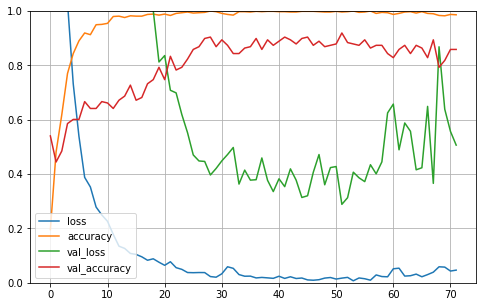

In [ ]:
plot1(history2)

# ResNet 152 0.8687

In [ ]:
base_model = keras.applications.resnet.ResNet152(weights = 'imagenet', include_top = False, input_shape = (96,96,3))

In [ ]:
def transfer1(model):
    x = model.output
    x = keras.layers.GlobalAveragePooling2D()(x)
    #x = keras.layers.Dense(200, activation='relu')(x)
    #x = keras.layers.Dense(200, activation='relu')(x)
    y = keras.layers.Dense(99, activation = 'softmax')(x)
    model =keras.Model(inputs = model.input, outputs = y)
    return model

In [ ]:
clf3 = transfer1(base_model)

In [ ]:
for layer in clf3.layers:
    layer.trainable = False

for layer in clf3.layers[-1:]:
    layer.trainable = True

In [ ]:
clf3.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.SGD(lr = 0.2, momentum=0.9, decay = 0.01), metrics = ['accuracy'])

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [ ]:
history3 = clf3.fit(training_set, validation_data= valid_set, epochs = 100, callbacks=[early_stopping])

Epoch 1/100
25/25 [==============================] - 13s 225ms/step - loss: 9.6146 - accuracy: 0.0114 - val_loss: 14.1610 - val_accuracy: 0.0253
Epoch 2/100
25/25 [==============================] - 3s 133ms/step - loss: 15.4200 - accuracy: 0.0253 - val_loss: 16.8727 - val_accuracy: 0.0354
Epoch 3/100
25/25 [==============================] - 3s 138ms/step - loss: 15.9796 - accuracy: 0.0391 - val_loss: 14.4151 - val_accuracy: 0.0758
Epoch 4/100
25/25 [==============================] - 3s 136ms/step - loss: 12.7869 - accuracy: 0.0556 - val_loss: 9.3677 - val_accuracy: 0.0758
Epoch 5/100
25/25 [==============================] - 3s 137ms/step - loss: 8.4455 - accuracy: 0.0758 - val_loss: 6.8032 - val_accuracy: 0.0859
Epoch 6/100
25/25 [==============================] - 3s 134ms/step - loss: 6.3841 - accuracy: 0.0732 - val_loss: 6.0263 - val_accuracy: 0.0960
Epoch 7/100
25/25 [==============================] - 3s 134ms/step - loss: 5.1954 - accuracy: 0.0732 - val_loss: 5.0367 - val_accuracy:

In [ ]:
for layer in clf3.layers[:len(clf3.layers)]:
    layer.trainable = True

In [ ]:
clf3.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.Adam(lr = 0.0001), metrics = ['accuracy'])

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

In [ ]:
history3 = clf3.fit(training_set, validation_data= valid_set, epochs = 300, callbacks=[early_stopping])

Epoch 1/300
25/25 [==============================] - 23s 368ms/step - loss: 0.0434 - accuracy: 0.9886 - val_loss: 3.1061 - val_accuracy: 0.5051
Epoch 2/300
25/25 [==============================] - 7s 276ms/step - loss: 0.0163 - accuracy: 0.9962 - val_loss: 1.4243 - val_accuracy: 0.6818
Epoch 3/300
25/25 [==============================] - 7s 279ms/step - loss: 0.0083 - accuracy: 0.9975 - val_loss: 1.3032 - val_accuracy: 0.7172
Epoch 4/300
25/25 [==============================] - 7s 277ms/step - loss: 0.0124 - accuracy: 0.9949 - val_loss: 0.9929 - val_accuracy: 0.7778
Epoch 5/300
25/25 [==============================] - 7s 276ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.6685 - val_accuracy: 0.8333
Epoch 6/300
25/25 [==============================] - 7s 275ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.6970 - val_accuracy: 0.8384
Epoch 7/300
25/25 [==============================] - 7s 276ms/step - loss: 0.0099 - accuracy: 0.9962 - val_loss: 0.5436 - val_accuracy: 0.858

In [ ]:
clf3.save('/content/drive/MyDrive/MSCA/msca31009/mod152_continued.h5')

In [ ]:
clf3.evaluate(valid_set)

7/7 [==============================] - 1s 97ms/step - loss: 0.5509 - accuracy: 0.8687


[0.5508700609207153, 0.868686854839325]

In [ ]:
clf3.evaluate(training_set)

25/25 [==============================] - 3s 108ms/step - loss: 6.7721e-04 - accuracy: 1.0000


[0.0006772069027647376, 1.0]

In [ ]:
#test_prob_image(clf3, target_size=(96,96))

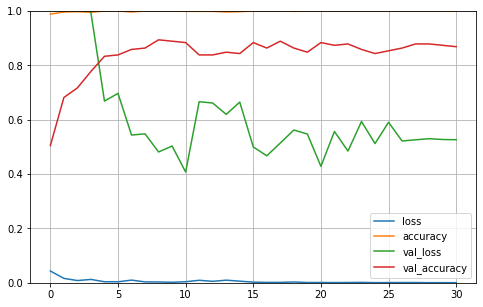

In [ ]:
plot1(history3)

# VGG 16. 0.8737

In [ ]:
base_model = keras.applications.VGG16(weights = 'imagenet', include_top = False, input_shape = (96,96,3))

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
clf4 = transfer(base_model)

In [ ]:
for layer in clf4.layers:
    layer.trainable = False

for layer in clf4.layers[-1:]:
    layer.trainable = True

In [ ]:
clf4.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.SGD(lr = 0.2, momentum=0.9, decay = 0.01), metrics = ['accuracy'])

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [ ]:
history4 = clf4.fit(training_set, validation_data= valid_set, epochs = 100, callbacks=[early_stopping])

Epoch 1/100
25/25 [==============================] - 6s 171ms/step - loss: 6.0785 - accuracy: 0.0164 - val_loss: 6.1948 - val_accuracy: 0.1162
Epoch 2/100
25/25 [==============================] - 3s 107ms/step - loss: 5.7929 - accuracy: 0.1149 - val_loss: 5.4456 - val_accuracy: 0.2475
Epoch 3/100
25/25 [==============================] - 3s 107ms/step - loss: 4.7766 - accuracy: 0.1831 - val_loss: 3.8140 - val_accuracy: 0.2172
Epoch 4/100
25/25 [==============================] - 3s 106ms/step - loss: 3.4961 - accuracy: 0.2513 - val_loss: 3.4164 - val_accuracy: 0.2828
Epoch 5/100
25/25 [==============================] - 3s 108ms/step - loss: 2.9610 - accuracy: 0.3384 - val_loss: 3.0517 - val_accuracy: 0.3737
Epoch 6/100
25/25 [==============================] - 3s 105ms/step - loss: 2.6406 - accuracy: 0.4205 - val_loss: 2.4816 - val_accuracy: 0.3788
Epoch 7/100
25/25 [==============================] - 3s 111ms/step - loss: 2.2285 - accuracy: 0.4571 - val_loss: 2.4047 - val_accuracy: 0.4596

In [ ]:
clf4.save('mod4.h5')

In [ ]:
clf4  = keras.models.load_model('mod4.h5')

In [ ]:
for layer in clf4.layers[:len(clf4.layers)]:
    layer.trainable = True

In [ ]:
clf4.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.Adam(lr = 0.0001), metrics = ['accuracy'])

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

In [ ]:
history4 = clf4.fit(training_set, validation_data= valid_set, epochs = 300, callbacks=[early_stopping])

Epoch 1/300
25/25 [==============================] - 6s 162ms/step - loss: 2.4584 - accuracy: 0.4268 - val_loss: 1.1831 - val_accuracy: 0.6111
Epoch 2/300
25/25 [==============================] - 3s 121ms/step - loss: 0.8565 - accuracy: 0.7285 - val_loss: 1.0118 - val_accuracy: 0.6465
Epoch 3/300
25/25 [==============================] - 3s 122ms/step - loss: 0.5317 - accuracy: 0.8245 - val_loss: 0.6307 - val_accuracy: 0.8030
Epoch 4/300
25/25 [==============================] - 3s 122ms/step - loss: 0.5927 - accuracy: 0.8030 - val_loss: 0.9155 - val_accuracy: 0.7273
Epoch 5/300
25/25 [==============================] - 3s 119ms/step - loss: 0.4197 - accuracy: 0.8624 - val_loss: 0.6996 - val_accuracy: 0.7576
Epoch 6/300
25/25 [==============================] - 3s 121ms/step - loss: 0.3677 - accuracy: 0.8927 - val_loss: 0.7625 - val_accuracy: 0.7424
Epoch 7/300
25/25 [==============================] - 3s 122ms/step - loss: 0.3831 - accuracy: 0.8725 - val_loss: 1.1005 - val_accuracy: 0.6616

In [ ]:
clf4.save('/content/drive/MyDrive/MSCA/msca31009/mod4_continued.h5')

In [ ]:
clf4.evaluate(valid_set)

7/7 [==============================] - 1s 76ms/step - loss: 0.4801 - accuracy: 0.8737


[0.4800673723220825, 0.8737373948097229]

In [ ]:
clf4.evaluate(training_set)

25/25 [==============================] - 2s 87ms/step - loss: 0.0554 - accuracy: 0.9874


[0.05541124567389488, 0.9873737096786499]

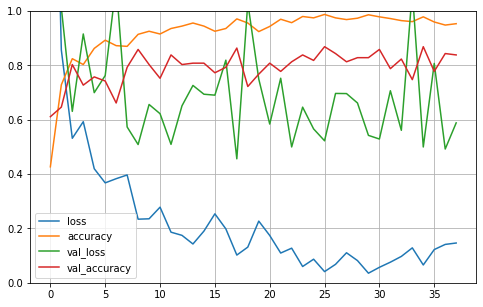

In [ ]:
plot1(history4)

# VGG 19. 0.8687

In [ ]:
base_model = keras.applications.VGG19(weights = 'imagenet', include_top = False, input_shape = (96,96,3))

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
clf6 = transfer(base_model)

In [ ]:
for layer in clf6.layers:
    layer.trainable = False

for layer in clf6.layers[-1:]:
    layer.trainable = True

In [ ]:
clf6.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.SGD(lr = 0.2, momentum=0.9, decay = 0.01), metrics = ['accuracy'])

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [ ]:
history6 = clf6.fit(training_set, validation_data= valid_set, epochs = 100, callbacks=[early_stopping])

Epoch 1/100
25/25 [==============================] - 4s 119ms/step - loss: 6.5961 - accuracy: 0.0126 - val_loss: 7.3841 - val_accuracy: 0.0657
Epoch 2/100
25/25 [==============================] - 3s 107ms/step - loss: 6.8083 - accuracy: 0.0896 - val_loss: 5.5572 - val_accuracy: 0.1162
Epoch 3/100
25/25 [==============================] - 3s 106ms/step - loss: 4.7987 - accuracy: 0.1755 - val_loss: 4.1431 - val_accuracy: 0.1717
Epoch 4/100
25/25 [==============================] - 3s 106ms/step - loss: 4.0843 - accuracy: 0.2159 - val_loss: 3.6001 - val_accuracy: 0.2525
Epoch 5/100
25/25 [==============================] - 3s 105ms/step - loss: 3.3955 - accuracy: 0.2917 - val_loss: 2.9496 - val_accuracy: 0.3030
Epoch 6/100
25/25 [==============================] - 3s 107ms/step - loss: 2.9551 - accuracy: 0.3245 - val_loss: 3.0764 - val_accuracy: 0.2980
Epoch 7/100
25/25 [==============================] - 3s 104ms/step - loss: 2.5705 - accuracy: 0.4003 - val_loss: 2.7195 - val_accuracy: 0.4040

In [ ]:
clf6.save('mod6.h5')

In [ ]:
clf6  = keras.models.load_model('mod6.h5')

In [ ]:
for layer in clf6.layers[:len(clf6.layers)]:
    layer.trainable = True

In [ ]:
clf6.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.Adam(lr = 0.0001), metrics = ['accuracy'])

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

In [ ]:
history6 = clf6.fit(training_set, validation_data= valid_set, epochs = 300, callbacks=[early_stopping])

Epoch 1/300
25/25 [==============================] - 4s 141ms/step - loss: 4.3203 - accuracy: 0.1641 - val_loss: 2.3779 - val_accuracy: 0.3081
Epoch 2/300
25/25 [==============================] - 3s 129ms/step - loss: 1.6700 - accuracy: 0.4861 - val_loss: 1.2496 - val_accuracy: 0.5909
Epoch 3/300
25/25 [==============================] - 3s 129ms/step - loss: 0.9449 - accuracy: 0.7159 - val_loss: 1.2147 - val_accuracy: 0.6061
Epoch 4/300
25/25 [==============================] - 3s 132ms/step - loss: 0.7894 - accuracy: 0.7525 - val_loss: 0.9161 - val_accuracy: 0.6970
Epoch 5/300
25/25 [==============================] - 3s 129ms/step - loss: 0.5099 - accuracy: 0.8346 - val_loss: 0.7086 - val_accuracy: 0.7828
Epoch 6/300
25/25 [==============================] - 3s 129ms/step - loss: 0.5081 - accuracy: 0.8409 - val_loss: 0.9376 - val_accuracy: 0.7020
Epoch 7/300
25/25 [==============================] - 3s 129ms/step - loss: 0.4587 - accuracy: 0.8434 - val_loss: 0.8012 - val_accuracy: 0.7273

In [ ]:
clf6.save('/content/drive/MyDrive/MSCA/msca31009/mod6_continued.h5')

In [ ]:
clf6.evaluate(valid_set)

7/7 [==============================] - 1s 85ms/step - loss: 0.4262 - accuracy: 0.8687


[0.42622867226600647, 0.868686854839325]

In [ ]:
clf6.evaluate(training_set)

25/25 [==============================] - 2s 96ms/step - loss: 0.0353 - accuracy: 0.9874


[0.03526226058602333, 0.9873737096786499]

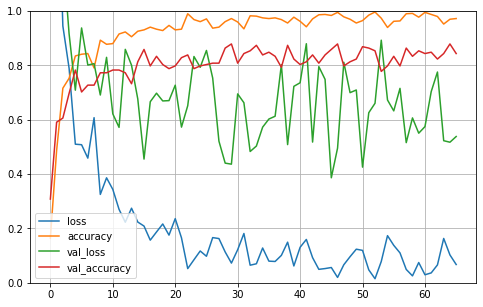

In [ ]:
plot1(history6)

# ResNet 50  0.7879

In [ ]:
base_model = keras.applications.ResNet50(weights = 'imagenet', include_top = False, input_shape = (96,96,3))

In [ ]:
def transfer1(model):
    x = model.output
    x = keras.layers.GlobalAveragePooling2D()(x)
    #x = keras.layers.Dense(200, activation='relu')(x)
    #x = keras.layers.Dense(100, activation='relu')(x)
    y = keras.layers.Dense(99, activation = 'softmax')(x)
    model =keras.Model(inputs = model.input, outputs = y)
    return model

In [ ]:
clf5 = transfer1(base_model)

In [ ]:
for layer in clf5.layers:
    layer.trainable = False

for layer in clf5.layers[-1:]:
    layer.trainable = True

In [ ]:
clf5.compile(loss = 'categorical_crossentropy', optimizer =keras.optimizers.SGD(lr = 0.02, momentum=0.9, decay = 0.01), metrics = ['accuracy'])

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [ ]:
history5 = clf5.fit(training_set, validation_data= valid_set, epochs = 100, callbacks=[early_stopping])

Epoch 1/100
25/25 [==============================] - 6s 149ms/step - loss: 5.1052 - accuracy: 0.0051 - val_loss: 5.0314 - val_accuracy: 0.0202
Epoch 2/100
25/25 [==============================] - 3s 113ms/step - loss: 5.0088 - accuracy: 0.0265 - val_loss: 4.7520 - val_accuracy: 0.0354
Epoch 3/100
25/25 [==============================] - 3s 116ms/step - loss: 4.6885 - accuracy: 0.0417 - val_loss: 4.4236 - val_accuracy: 0.0606
Epoch 4/100
25/25 [==============================] - 3s 112ms/step - loss: 4.4521 - accuracy: 0.0518 - val_loss: 4.3204 - val_accuracy: 0.0707
Epoch 5/100
25/25 [==============================] - 3s 112ms/step - loss: 4.3704 - accuracy: 0.0745 - val_loss: 4.1321 - val_accuracy: 0.0909
Epoch 6/100
25/25 [==============================] - 3s 114ms/step - loss: 4.1166 - accuracy: 0.0947 - val_loss: 3.9542 - val_accuracy: 0.1465
Epoch 7/100
25/25 [==============================] - 3s 116ms/step - loss: 4.0483 - accuracy: 0.0884 - val_loss: 3.9655 - val_accuracy: 0.1263

In [ ]:
clf5.save('mod5.h5')

In [ ]:
for layer in clf5.layers[:len(clf5.layers)]:
    layer.trainable = True

In [ ]:
clf5.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.Adam(lr = 0.0001), metrics = ['accuracy'])

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

In [ ]:
history5 = clf5.fit(training_set, validation_data= valid_set, epochs = 300, callbacks=[early_stopping])

Epoch 1/300
25/25 [==============================] - 11s 208ms/step - loss: 3.7215 - accuracy: 0.1641 - val_loss: 5.7434 - val_accuracy: 0.0202
Epoch 2/300
25/25 [==============================] - 3s 135ms/step - loss: 1.7225 - accuracy: 0.5480 - val_loss: 7.5040 - val_accuracy: 0.0152
Epoch 3/300
25/25 [==============================] - 3s 137ms/step - loss: 0.9202 - accuracy: 0.7525 - val_loss: 6.0893 - val_accuracy: 0.0101
Epoch 4/300
25/25 [==============================] - 4s 140ms/step - loss: 0.6060 - accuracy: 0.8485 - val_loss: 5.7743 - val_accuracy: 0.0202
Epoch 5/300
25/25 [==============================] - 4s 138ms/step - loss: 0.4163 - accuracy: 0.8977 - val_loss: 5.6375 - val_accuracy: 0.0253
Epoch 6/300
25/25 [==============================] - 3s 137ms/step - loss: 0.3455 - accuracy: 0.9040 - val_loss: 6.0314 - val_accuracy: 0.0101
Epoch 7/300
25/25 [==============================] - 3s 133ms/step - loss: 0.2563 - accuracy: 0.9343 - val_loss: 5.8482 - val_accuracy: 0.015

In [ ]:
clf5.save('/content/drive/MyDrive/MSCA/msca31009/mod5_continued.h5')

In [ ]:
clf5.evaluate(valid_set)

7/7 [==============================] - 1s 82ms/step - loss: 0.7326 - accuracy: 0.7879


[0.7326004505157471, 0.7878788113594055]

In [ ]:
clf5.evaluate(training_set)

25/25 [==============================] - 2s 92ms/step - loss: 0.1058 - accuracy: 0.9722


[0.10581019520759583, 0.9722222089767456]

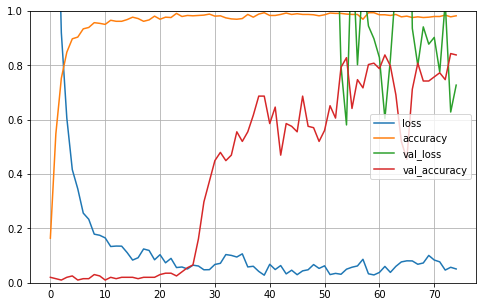

In [ ]:
plot1(history5)

# VGG16 from scratch not converge

In [ ]:
def vgg16_scratch():
  model = keras.Sequential([
                            keras.layers.Conv2D(filters = 64, kernel_size = (3,3), padding='same', activation='relu', input_shape = (96,96,3)),
                            keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"),
                            keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
                            keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
                            keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
                            keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
                            keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
                            keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
                            keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
                            keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
                            keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
                            #keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
                            #keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
                            #keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
                            #keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
                            #keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
                            #keras.layers.Flatten(),
                            #keras.layers.Dense(units=1000, activation='relu', kernel_initializer='he_normal'),
                            #keras.layers.Dense(units=5000, activation='relu', kernel_initializer='he_normal'),
                            keras.layers.GlobalAveragePooling2D(),
                            keras.layers.Dense(units= 99, activation='softmax')

  ])
  return model

In [ ]:
vgg = vgg16_scratch()

In [ ]:

#vgg.summary()

In [ ]:
vgg.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

In [ ]:
history7 = vgg.fit(training_set, validation_data= valid_set, epochs = 300, callbacks=[early_stopping])

Epoch 1/300
25/25 [==============================] - 4s 131ms/step - loss: 4.6018 - accuracy: 0.0025 - val_loss: 4.5951 - val_accuracy: 0.0101
Epoch 2/300
25/25 [==============================] - 3s 119ms/step - loss: 4.5959 - accuracy: 0.0063 - val_loss: 4.5951 - val_accuracy: 0.0101
Epoch 3/300
25/25 [==============================] - 3s 120ms/step - loss: 4.5957 - accuracy: 0.0063 - val_loss: 4.5951 - val_accuracy: 0.0101
Epoch 4/300
25/25 [==============================] - 3s 124ms/step - loss: 4.5957 - accuracy: 0.0101 - val_loss: 4.5951 - val_accuracy: 0.0101
Epoch 5/300
10/25 [===========>..................] - ETA: 1s - loss: 4.5954 - accuracy: 0.0063

KeyboardInterrupt: ignored

# mlp1 for numerical data 0.9848

In [ ]:
def NN():
  model = keras.Sequential([
                            keras.layers.Dense(units= 2000, activation='relu', input_dim = 192),
                            keras.layers.Dropout(0.2),
                            keras.layers.Dense(units = 1000, activation='relu'),
                            keras.layers.Dropout(0.2),
                            keras.layers.Dense(units = 500, activation= 'relu'),
                            keras.layers.Dropout(0.2),
                            keras.layers.Dense(units = 250, activation= 'relu'),
                            keras.layers.Dropout(0.2),
                            keras.layers.Dense(units = 125, activation= 'relu'),
                            keras.layers.Dropout(0.2),
                            keras.layers.Dense(units = 99, activation = 'softmax')
  ])
  return model

In [ ]:
clf7 = NN()

In [ ]:
clf7.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
earlystop = keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True)

In [ ]:
histort7 = clf7.fit(X_train, y_train1,  batch_size= 128, epochs=400, validation_data=(X_valid,y_valid1), callbacks=[earlystop])

Epoch 1/400
7/7 [==============================] - 1s 94ms/step - loss: 4.5386 - accuracy: 0.0265 - val_loss: 4.1513 - val_accuracy: 0.1768
Epoch 2/400
7/7 [==============================] - 0s 68ms/step - loss: 4.0943 - accuracy: 0.0821 - val_loss: 3.4003 - val_accuracy: 0.2727
Epoch 3/400
7/7 [==============================] - 0s 68ms/step - loss: 3.4506 - accuracy: 0.2045 - val_loss: 2.5438 - val_accuracy: 0.4091
Epoch 4/400
7/7 [==============================] - 0s 69ms/step - loss: 2.8164 - accuracy: 0.3068 - val_loss: 1.7063 - val_accuracy: 0.6818
Epoch 5/400
7/7 [==============================] - 0s 70ms/step - loss: 2.0814 - accuracy: 0.4747 - val_loss: 1.0015 - val_accuracy: 0.8131
Epoch 6/400
7/7 [==============================] - 0s 68ms/step - loss: 1.6323 - accuracy: 0.5669 - val_loss: 0.6895 - val_accuracy: 0.8586
Epoch 7/400
7/7 [==============================] - 0s 67ms/step - loss: 1.0911 - accuracy: 0.6932 - val_loss: 0.4248 - val_accuracy: 0.9091
Epoch 8/400
7/7 [===

In [ ]:
clf7.evaluate(X_valid,y_valid1)

7/7 [==============================] - 0s 3ms/step - loss: 0.0350 - accuracy: 0.9848


[0.03502948582172394, 0.9848484992980957]

In [ ]:
clf7.save('/content/drive/MyDrive/msca31009/NN.h5')

In [ ]:
clf7 = keras.models.load_model('/content/drive/MyDrive/MSCA/msca31009/NN.h5')

In [ ]:
clf7.evaluate(X_train,y_train1)

25/25 [==============================] - 0s 2ms/step - loss: 2.1558e-05 - accuracy: 1.0000


[2.1557971194852144e-05, 1.0]

In [ ]:
test_prob(clf7)

created file


# baseline 2.  0.6465

In [ ]:
datagen1 = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                       horizontal_flip = True,
                                                       vertical_flip = True)

In [ ]:
target_size = (96, 96)
batch_size = 32
class_mode = 'categorical'

In [ ]:
training_set2 = datagen1.flow_from_directory(directory= train_dir, 
                                           target_size= target_size, 
                                           batch_size= batch_size, 
                                           class_mode= class_mode)

Found 792 images belonging to 99 classes.


In [ ]:
valid_set2 = datagen1.flow_from_directory(directory= valid_dir, 
                                        target_size= target_size, 
                                        batch_size= batch_size, 
                                        class_mode= class_mode)

Found 198 images belonging to 99 classes.


In [ ]:
def base_line2():
    image = keras.Input(shape=(96, 96, 3))
    x = keras.layers.Conv2D(filters=8, kernel_size=(5,5), input_shape=(96,96,3), activation='relu',padding='same')(image)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu', padding='same')(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(units = 100, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    out = keras.layers.Dense(units = 99, activation='softmax')(x)
    model = keras.Model(inputs=image, outputs=out)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [ ]:
clf8 = base_line2()

In [ ]:
earlystop = keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True)

In [ ]:
history8 = clf8.fit(training_set2, validation_data = valid_set2,epochs=300, callbacks=[earlystop])

Epoch 1/300
25/25 [==============================] - 3s 107ms/step - loss: 4.6557 - accuracy: 0.0139 - val_loss: 4.5717 - val_accuracy: 0.0202
Epoch 2/300
25/25 [==============================] - 2s 100ms/step - loss: 4.5404 - accuracy: 0.0164 - val_loss: 4.4391 - val_accuracy: 0.0606
Epoch 3/300
25/25 [==============================] - 2s 99ms/step - loss: 4.3700 - accuracy: 0.0467 - val_loss: 4.0929 - val_accuracy: 0.1010
Epoch 4/300
25/25 [==============================] - 3s 101ms/step - loss: 4.1167 - accuracy: 0.0795 - val_loss: 3.8362 - val_accuracy: 0.1717
Epoch 5/300
25/25 [==============================] - 2s 99ms/step - loss: 3.8544 - accuracy: 0.1061 - val_loss: 3.4802 - val_accuracy: 0.2424
Epoch 6/300
25/25 [==============================] - 2s 100ms/step - loss: 3.6363 - accuracy: 0.1364 - val_loss: 3.2191 - val_accuracy: 0.2677
Epoch 7/300
25/25 [==============================] - 2s 101ms/step - loss: 3.3403 - accuracy: 0.2008 - val_loss: 2.9610 - val_accuracy: 0.3232
E

In [ ]:
clf8.evaluate(valid_set2)

7/7 [==============================] - 1s 72ms/step - loss: 1.1648 - accuracy: 0.6414


[1.1648353338241577, 0.6414141654968262]

In [ ]:
clf8.save('/content/drive/MyDrive/msca31009/baseline2.h5')

In [ ]:
test_prob_image(clf8)

created file


# cnn and mlp   0.9899

In [ ]:
train_Image = []
for i in train_ID:
  path = os.path.join(original_path,'{}.jpg'.format(i+1))
  image = keras.preprocessing.image.load_img(path,target_size=(96,96))
  arr = keras.preprocessing.image.img_to_array(image)
  train_Image.append(arr)

In [ ]:
valid_Image = []
for i in valid_ID:
  path = os.path.join(original_path,'{}.jpg'.format(i+1))
  image = keras.preprocessing.image.load_img(path,target_size=(96,96))
  arr = keras.preprocessing.image.img_to_array(image)
  valid_Image.append(arr)

In [ ]:
generator2 = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                       horizontal_flip = True,
                                                       vertical_flip = True)

In [ ]:
training_set2 = generator2.flow(np.array(train_Image), y_train1,shuffle=False, batch_size= 792)

In [ ]:
valid_set2 = generator2.flow(np.array(valid_Image), y_valid1,shuffle=False, batch_size= 198)

In [ ]:
training_image2, train_label2 = next(training_set2)

In [ ]:
valid_image2, valid_label2 = next(valid_set2)

In [ ]:
def cnn():
    image = keras.Input(shape=(96, 96, 3))
    x1 = keras.layers.Conv2D(filters=8, kernel_size=(5,5), input_shape=(96,96,3), activation='relu',padding='same')(image)
    x1 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x1)
    x1 = keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu', padding='same')(x1)
    x1 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x1)
    x1 = keras.layers.Flatten()(x1)
    x1 = keras.layers.Dense(units = 100, activation='relu')(x1)
    x1 = keras.layers.Dropout(0.5)(x1)
    model = keras.models.Model(inputs = image, outputs = x1)
    return model
def mlp():
    numerical = keras.Input(shape=(192,))
    #x2 = keras.layers.Dense(units= 2000, activation='relu')(numerical)
    #x2 = keras.layers.Dropout(0.2)(x2)
    #x2 = keras.layers.Dense(units = 1000, activation='relu')(x2)
    #x2 = keras.layers.Dropout(0.2)(x2)
    #x2 = keras.layers.Dense(units = 500, activation= 'relu')(x2)
    #x2 = keras.layers.Dropout(0.2)(x2)
    #x2 = keras.layers.Dense(units = 250, activation= 'relu')(numerical)
    #x2 = keras.layers.Dropout(0.2)(x2)
    x2 = keras.layers.Dense(units = 100, activation= 'relu')(numerical)
    x2 = keras.layers.Dropout(0.2)(x2)
    model = keras.models.Model(inputs = numerical, outputs = x2)
    return model

In [ ]:
def merge2(cnn, mlp):
    input1 = cnn.output
    input2 = mlp.output
    concatenated = keras.layers.concatenate([input1, input2])
    concatenated = keras.layers.Dense(units = 100, activation='relu')(concatenated)
    concatenated = keras.layers.Dropout(0.5)(concatenated)

    out = keras.layers.Dense(units = 99, activation='softmax')(concatenated)

    model = keras.models.Model(inputs=[cnn.input, mlp.input], outputs=out)
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

    return model

In [ ]:
mod1 = cnn()
mod2 = mlp()

In [ ]:
clf10 = merge2(mod1, mod2)

In [ ]:
earlystop = keras.callbacks.EarlyStopping(patience=60,restore_best_weights=True)

In [ ]:
#clf10.summary()

In [ ]:
history10 = clf10.fit(x=[training_image2, X_train],
                    y= y_train1,
                    epochs = 300,
                    callbacks = [earlystop],
                    validation_data = ([valid_image2, X_valid], y_valid1))

Epoch 1/300
25/25 [==============================] - 9s 299ms/step - loss: 4.5882 - accuracy: 0.0202 - val_loss: 4.1239 - val_accuracy: 0.1970
Epoch 2/300
25/25 [==============================] - 7s 291ms/step - loss: 4.1294 - accuracy: 0.0808 - val_loss: 3.6586 - val_accuracy: 0.3535
Epoch 3/300
25/25 [==============================] - 7s 291ms/step - loss: 3.6210 - accuracy: 0.1818 - val_loss: 3.0562 - val_accuracy: 0.5101
Epoch 4/300
25/25 [==============================] - 7s 290ms/step - loss: 3.1588 - accuracy: 0.2323 - val_loss: 2.5195 - val_accuracy: 0.6566
Epoch 5/300
25/25 [==============================] - 7s 290ms/step - loss: 2.6969 - accuracy: 0.3586 - val_loss: 2.0247 - val_accuracy: 0.7222
Epoch 6/300
25/25 [==============================] - 7s 291ms/step - loss: 2.3437 - accuracy: 0.4318 - val_loss: 1.6543 - val_accuracy: 0.8030
Epoch 7/300
25/25 [==============================] - 7s 292ms/step - loss: 2.0435 - accuracy: 0.5063 - val_loss: 1.3127 - val_accuracy: 0.8333

In [ ]:
#clf10.save('/content/drive/MyDrive/MSCA/msca31009/merge2.h5')

In [ ]:
clf10 = keras.models.load_model('/content/drive/MyDrive/MSCA/msca31009/merge2.h5')

In [ ]:
clf10.evaluate(([valid_image2, X_valid]), y = y_valid1)

7/7 [==============================] - 1s 72ms/step - loss: 0.0397 - accuracy: 0.9949


[0.03966266289353371, 0.9949495196342468]

In [ ]:
clf10.evaluate(([training_image2, X_train]), y = y_train1)

25/25 [==============================] - 2s 83ms/step - loss: 1.9001e-06 - accuracy: 1.0000


[1.9001436157850549e-06, 1.0]

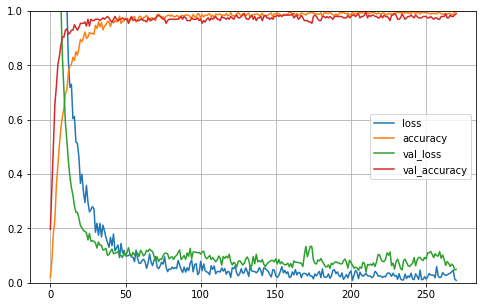

In [ ]:
plot1(history10)

# test

In [ ]:
def test_prob(model):
  prob = model.predict_proba(X_testS)
  df_test = pd.DataFrame(prob, index= test_id, columns=encoder.classes_)
  df_test.to_csv('submission.csv', header=True)
  return print('created file')

In [ ]:
def test_prob_image(model, target_size=(96,96)):
  test_image = []

  for i in test_id:
    path = os.path.join(original_path,'{}.jpg'.format(i+1))
    image = keras.preprocessing.image.load_img(path,target_size=target_size)
    arr = keras.preprocessing.image.img_to_array(image)/255
    test_image.append(arr)
  prob = model.predict(np.array(test_image))
  df_test = pd.DataFrame(prob, index= test_id, columns=encoder.classes_)
  df_test.to_csv('submission.csv', header=True)
  return print('created file')

# mlp 2

In [ ]:
def mlp2():
  inputs = keras.Input(shape = (192,))
  x = keras.layers.Dense(1500,input_dim=192,  kernel_initializer='uniform', activation='relu')(inputs)
  x = keras.layers.Dropout(0.1)(x)
  x = keras.layers.Dense(1500, activation='sigmoid')(x)
  x = keras.layers.Dropout(0.1)(x)
  x = keras.layers.Dense(99, activation='softmax')(x)
  model = keras.models.Model(inputs = inputs, outputs = x)
  model.compile(loss='categorical_crossentropy',optimizer='rmsprop', metrics = ["accuracy"])
  return model

In [ ]:
clf11 = mlp2()

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=280)

In [ ]:
history = clf11.fit(X_train,y_train1,batch_size=192, epochs=800 ,verbose=1,validation_data = (X_valid,y_valid1), callbacks=[early_stopping])

Epoch 1/800
5/5 [==============================] - 1s 38ms/step - loss: 4.8210 - accuracy: 0.0720 - val_loss: 3.6178 - val_accuracy: 0.2323
Epoch 2/800
5/5 [==============================] - 0s 9ms/step - loss: 2.6021 - accuracy: 0.5164 - val_loss: 2.3628 - val_accuracy: 0.3434
Epoch 3/800
5/5 [==============================] - 0s 10ms/step - loss: 1.5285 - accuracy: 0.7235 - val_loss: 1.8262 - val_accuracy: 0.4747
Epoch 4/800
5/5 [==============================] - 0s 9ms/step - loss: 1.0366 - accuracy: 0.8308 - val_loss: 1.2164 - val_accuracy: 0.6465
Epoch 5/800
5/5 [==============================] - 0s 11ms/step - loss: 0.6594 - accuracy: 0.8990 - val_loss: 0.7653 - val_accuracy: 0.8182
Epoch 6/800
5/5 [==============================] - 0s 9ms/step - loss: 0.4324 - accuracy: 0.9545 - val_loss: 0.6843 - val_accuracy: 0.8333
Epoch 7/800
5/5 [==============================] - 0s 9ms/step - loss: 0.3234 - accuracy: 0.9609 - val_loss: 0.5044 - val_accuracy: 0.8788
Epoch 8/800
5/5 [=======

In [ ]:
#$clf11.save('/content/drive/MyDrive/MSCA/msca31009/NN2.h5')

In [ ]:
clf11 =keras.models.load_model('/content/drive/MyDrive/MSCA/msca31009/NN2.h5')

In [ ]:
clf11.evaluate(X_valid, y_valid1)

7/7 [==============================] - 0s 3ms/step - loss: 0.0198 - accuracy: 0.9899


[0.019824206829071045, 0.9898989796638489]

In [ ]:
clf11.evaluate(X_train, y_train1)

25/25 [==============================] - 0s 2ms/step - loss: 1.6557e-08 - accuracy: 1.0000


[1.655684478407693e-08, 1.0]

In [ ]:
def test_prob(model):
  prob = model.predict_proba(X_testS)
  df_test = pd.DataFrame(prob, index= test_id, columns=encoder.classes_)
  df_test.to_csv('submission.csv', header=True)
  return print('created file')

In [ ]:
test_prob(clf11)

created file


# presentation

In [ ]:
def plot1(history):
  pd.DataFrame(history.history).plot(figsize = (8,5))
  plt.grid(True)
  plt.gca().set_ylim(0,1)
  plt.show()

(-0.5, 600.5, 387.5, -0.5)

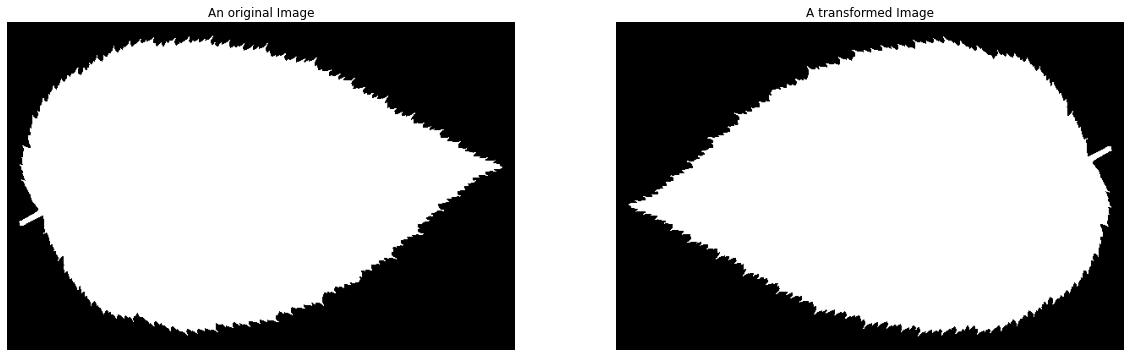

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
idx = np.random.choice(range(1000))
path = os.path.join(original_path, '{}.jpg'.format(idx))
image = plt.imread(path,format = 'jpg')
axes[0].imshow(image,cmap="gray")
axes[0].set_title('An original Image')
axes[0].axis('off')

aug_image = datagen.random_transform(image)
axes[1].imshow(aug_image, cmap="gray")
axes[1].set_title('A transformed Image')
axes[1].axis('off')

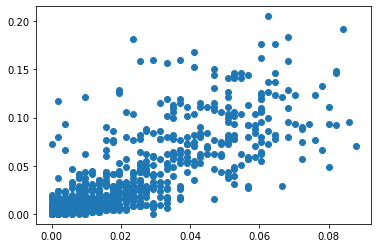

In [ ]:
# correlation
import seaborn as sns

plt.scatter(train['margin1'],train['margin2'])
plt.show()

In [ ]:
train[['margin1','margin2']].corr()

,margin1,margin2
margin1,1.00000,0.80639
margin2,0.80639,1.00000


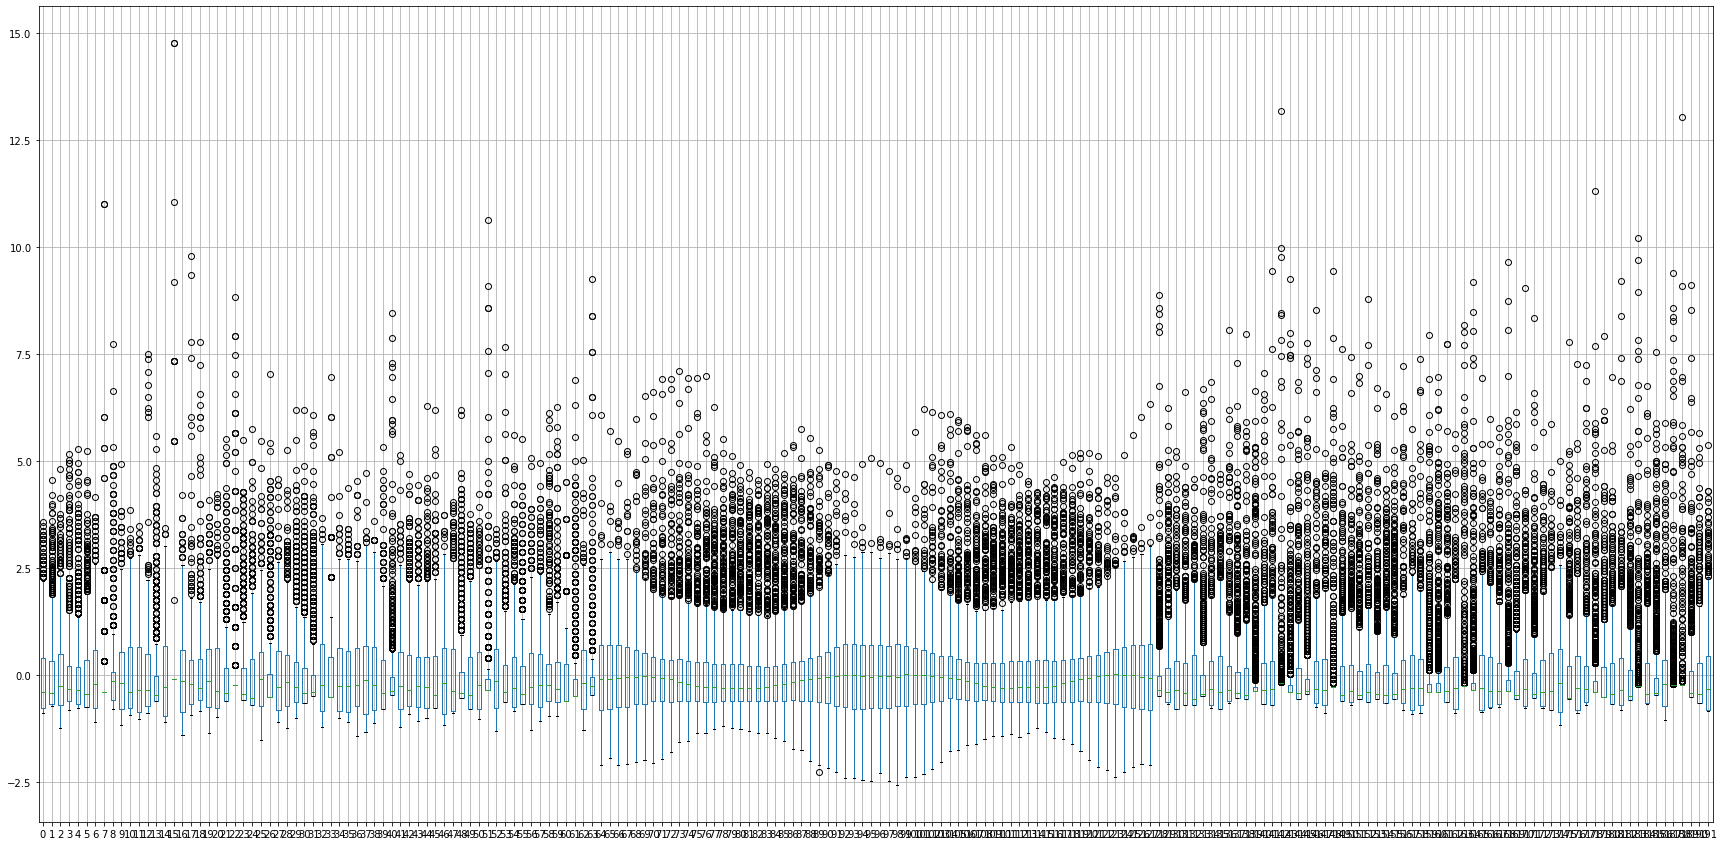

In [ ]:
plt.figure(figsize=(30,15))
pd.DataFrame(X_scaled).boxplot()

In [ ]:
train.corr()

,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,margin10,margin11,margin12,margin13,margin14,margin15,margin16,margin17,margin18,margin19,margin20,margin21,margin22,margin23,margin24,margin25,margin26,margin27,margin28,margin29,margin30,margin31,margin32,margin33,margin34,margin35,margin36,margin37,margin38,margin39,margin40,...,texture25,texture26,texture27,texture28,texture29,texture30,texture31,texture32,texture33,texture34,texture35,texture36,texture37,texture38,texture39,texture40,texture41,texture42,texture43,texture44,texture45,texture46,texture47,texture48,texture49,texture50,texture51,texture52,texture53,texture54,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
margin1,1.000000,0.806390,-0.182829,-0.297807,-0.475874,0.767718,0.066273,-0.094137,-0.181496,0.397138,0.737461,-0.528224,0.489317,-0.370460,-0.540974,-0.072127,0.316704,0.283239,-0.234398,0.325947,-0.433734,-0.404022,-0.142871,-0.315616,-0.452295,-0.190360,-0.361443,-0.558431,0.079726,-0.246912,-0.449652,-0.378156,0.597343,-0.176148,0.727001,0.687178,-0.078347,-0.465053,-0.524927,-0.462596,...,0.050617,-0.038014,0.041132,0.141785,-0.107082,-0.041502,-0.097229,-0.173384,-0.085094,0.188244,0.015550,-0.119741,-0.012150,0.150336,-0.041297,-0.060674,-0.002525,0.088347,-0.055831,0.071037,0.073072,0.132549,-0.112418,0.061727,-0.105793,-0.113374,-0.068991,-0.116994,-0.165543,-0.101943,0.137158,-0.047771,0.126227,-0.024139,-0.168201,0.035072,-0.007581,-0.033159,-0.075171,0.030414
margin2,0.806390,1.000000,-0.204640,-0.315953,-0.444312,0.825762,-0.083273,-0.086428,-0.120276,0.162587,0.805064,-0.489808,0.647166,-0.316377,-0.503059,-0.068356,0.135000,0.345410,-0.226020,0.062345,-0.421253,-0.364703,-0.136586,-0.302345,-0.397290,-0.342079,-0.316699,-0.544266,0.071445,-0.364163,-0.402669,-0.330662,0.373034,-0.155309,0.536119,0.633975,-0.184035,-0.453749,-0.506080,-0.426021,...,-0.001198,-0.046297,-0.010875,0.192409,-0.097583,-0.075650,-0.069725,-0.131603,-0.115030,0.176535,0.019144,-0.098242,-0.006745,0.181216,-0.087044,-0.092380,-0.043991,0.058825,-0.079107,0.031053,0.072819,0.145347,-0.063309,0.107823,-0.130133,-0.127546,-0.055311,-0.071952,-0.164018,-0.074003,0.154407,-0.021096,0.123834,-0.063654,-0.157842,0.081069,-0.007057,-0.037405,-0.098957,-0.029532
margin3,-0.182829,-0.204640,1.000000,0.120042,-0.185007,-0.163976,0.095449,0.024350,-0.000042,0.008772,-0.261371,-0.004085,-0.048698,0.095701,0.050113,-0.054076,-0.130220,-0.092062,-0.164152,0.012338,0.042328,-0.282862,-0.145334,-0.255676,-0.116910,0.040840,-0.209353,0.150049,0.246209,0.054936,-0.304381,-0.292799,-0.133807,-0.045337,-0.068513,-0.187569,0.680851,0.586314,0.079533,-0.109956,...,0.006825,-0.026222,0.077551,0.060833,-0.033625,-0.005056,-0.002509,0.088626,-0.043983,0.100356,0.039350,0.199391,-0.046014,0.031064,0.047732,0.081965,0.027886,-0.044844,0.012868,0.067403,0.012663,0.077332,-0.054151,0.073097,-0.040192,-0.109179,-0.112933,0.072707,-0.001058,-0.026245,0.047347,-0.027618,0.007261,-0.021390,0.033505,-0.019850,0.084957,-0.081999,-0.148193,0.061780
margin4,-0.297807,-0.315953,0.120042,1.000000,0.029480,-0.261437,-0.268271,-0.047693,0.227543,-0.173986,-0.172503,-0.202576,-0.238041,0.338136,-0.259813,-0.021615,-0.047704,0.093686,0.362009,0.056523,-0.138539,-0.194713,-0.004602,-0.144124,0.031567,0.076747,-0.120713,0.442599,0.467451,0.264924,-0.167772,-0.105741,-0.048612,-0.094700,-0.265846,-0.193072,0.090006,-0.004696,-0.211244,-0.202604,...,0.064296,-0.092171,-0.100644,0.122651,-0.038986,0.205614,-0.102292,0.206097,0.001501,-0.091901,0.267650,0.418101,-0.051318,-0.098795,-0.034738,-0.035576,-0.072381,0.246793,-0.106592,-0.101322,-0.075644,0.034912,-0.097367,0.067593,0.135671,0.072786,-0.015812,0.308288,-0.076214,-0.143516,-0.071974,-0.009537,-0.050529,-0.044318,0.088857,-0.052317,0.320644,-0.073886,0.050970,0.014343
margin5,-0.475874,-0.444312,-0.185007,0.029480,1.000000,-0.438587,-0.108178,0.056557,0.196745,-0.320647,-0.514981,0.373

In [15]:
((abs(train.corr()) >0.5) & (train.corr() <1)).sum().values

array([12, 10,  2,  2, 12,  8,  2,  0,  0,  6, 20, 14,  6,  5, 18,  0,  2,
        4,  2,  4,  7,  9,  0,  2, 12,  3, 10, 10,  4,  2, 15,  8, 12,  0,
        9,  8,  2,  4, 15, 11,  9,  2,  3, 10,  5, 16,  9,  7,  8,  4, 12,
        4,  2, 11,  3, 11,  3,  9,  3,  2,  0,  7,  3,  4, 33, 36, 39, 45,
       56, 63, 63, 63, 62, 55, 52, 49, 48, 47, 45, 45, 45, 45, 45, 46, 48,
       50, 54, 58, 63, 63, 63, 63, 47, 40, 37, 34, 33, 33, 37, 43, 50, 63,
       63, 63, 63, 56, 52, 49, 48, 46, 46, 45, 44, 45, 45, 47, 48, 51, 54,
       60, 63, 63, 63, 57, 45, 40, 35, 34,  2,  3,  4,  4,  3,  2,  1,  3,
        0,  3,  2,  1,  3,  1,  1,  1,  2,  0,  2,  5,  3,  1,  2,  2,  0,
        2,  3,  2,  2,  3,  2,  2,  1,  4,  5,  4,  1,  3,  5,  4,  0,  3,
        2,  1,  2,  2,  0,  1,  1,  2,  2,  0,  2,  2,  1,  2,  2,  2,  0,
        1,  3,  3,  0,  1])

In [ ]:
import seaborn as sns

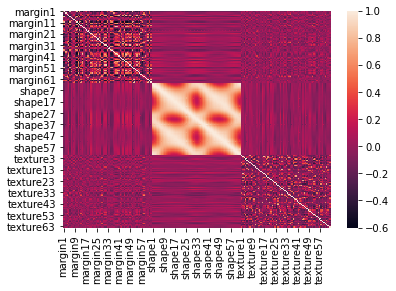

In [ ]:
sns.heatmap(train.corr())

In [ ]:
clf = merge2(mod1, mod2)

In [ ]:
from tensorflow.keras.utils import plot_model

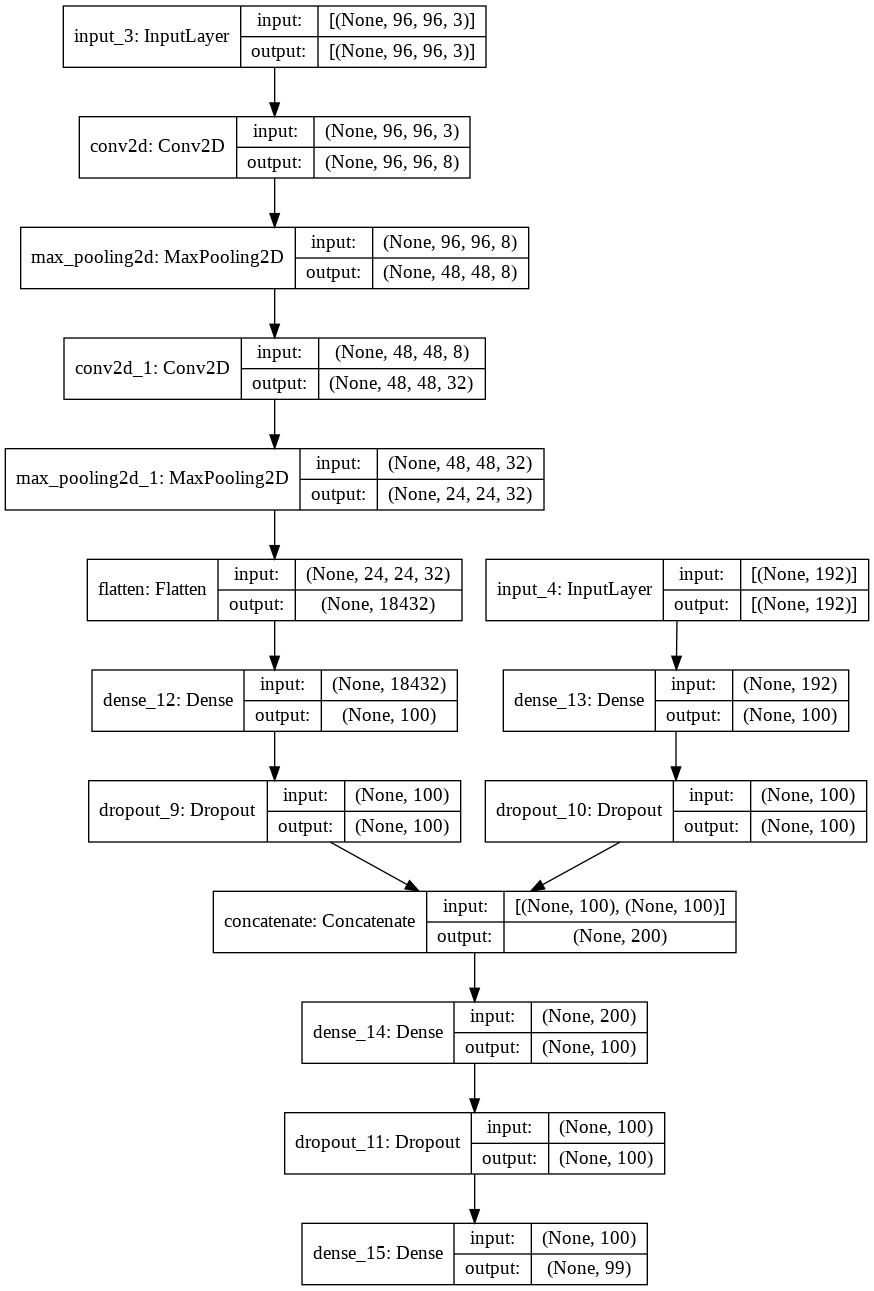

In [ ]:
plot_model(clf, show_shapes=True, show_layer_names= True)